### ニューラルネットワークで異常検知

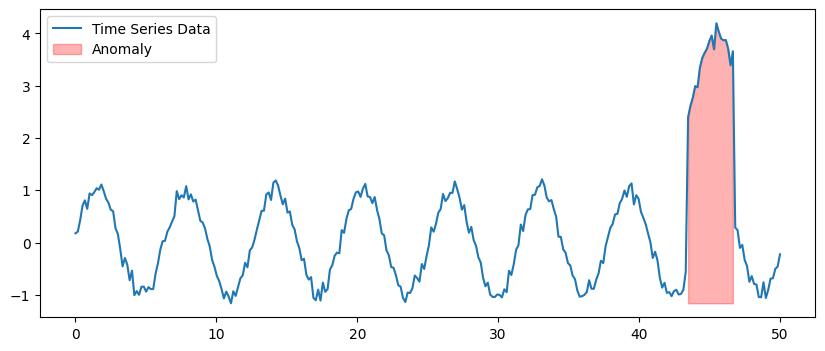

Epoch 0: Loss = 1.1879950761795044
Epoch 1: Loss = 0.6692479252815247
Epoch 2: Loss = 0.3030625283718109
Epoch 3: Loss = 0.068288654088974
Epoch 4: Loss = 0.015781758353114128


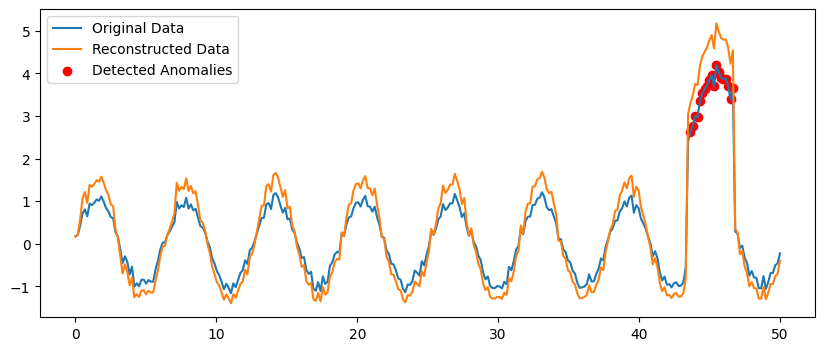

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam

# データの生成
np.random.seed(0)
time = np.linspace(0, 50, 300)
data = np.sin(time) + np.random.normal(scale=0.1, size=300)
data[260:280] += 3  # 異常を追加

plt.figure(figsize=(10, 4))
plt.plot(time, data, label='Time Series Data')
plt.fill_between(time[260:280], data.min(), data[260:280], color='red', alpha=0.3, label='Anomaly')
plt.legend()
plt.show()

class SimpleDDPM(nn.Module):
    def __init__(self):
        super(SimpleDDPM, self).__init__()
        self.fc1 = nn.Linear(1, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# データをTensorに変換
data_tensor = torch.tensor(data.reshape(-1, 1), dtype=torch.float32)

# モデルとオプティマイザ
model = SimpleDDPM()
optimizer = Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# 訓練
epochs = 5
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(data_tensor)
    loss = criterion(output, data_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 1 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')

model.eval()
with torch.no_grad():
    reconstructed = model(data_tensor).numpy().flatten()
    error = np.abs(reconstructed - data)

# 閾値を設定して異常を検出
threshold = error.mean() + 2 * error.std()
anomalies = np.where(error > threshold)[0]

plt.figure(figsize=(10, 4))
plt.plot(time, data, label='Original Data')
plt.plot(time, reconstructed, label='Reconstructed Data')
plt.scatter(time[anomalies], data[anomalies], color='red', label='Detected Anomalies')
plt.legend()
plt.show()


### 訓練データと正解データを同じものにして一つのデータを学習する

Epoch 0: Loss = 0.4676811397075653
Epoch 100: Loss = 2.5751354769454338e-05
Epoch 200: Loss = 3.869486135954503e-06
Epoch 300: Loss = 9.099833846448746e-07
Epoch 400: Loss = 4.000377202828531e-07
Epoch 500: Loss = 2.8650538297370076e-07
Epoch 600: Loss = 2.3177695140930155e-07
Epoch 700: Loss = 1.8878255048093706e-07
Epoch 800: Loss = 1.5687757581872575e-07
Epoch 900: Loss = 1.333948489445902e-07


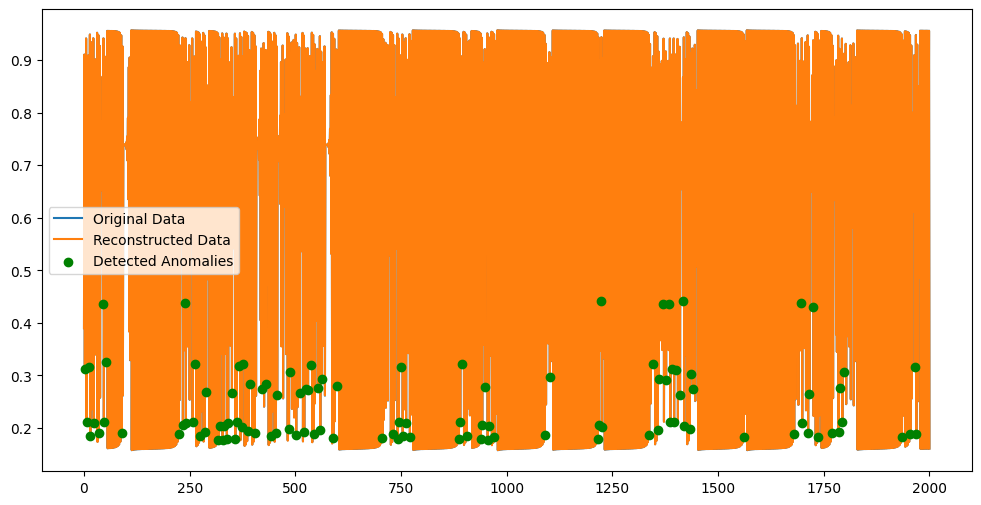

In [48]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt

# データの読み込み
file_path = 'data_3.csv'
data_df = pd.read_csv(file_path)

# データをPyTorchのテンソルに変換します。
# データは1次元の時系列データとして扱います。
data_tensor = torch.tensor(data_df.values, dtype=torch.float32).flatten()

# DDPMモデルの定義
class SimpleDDPM(nn.Module):
    def __init__(self):
        super(SimpleDDPM, self).__init__()
        # 3層の全結合ネットワーク
        self.fc1 = nn.Linear(1, 50)  # 入力層から中間層へ
        self.fc2 = nn.Linear(50, 50)  # 中間層
        self.fc3 = nn.Linear(50, 1)   # 中間層から出力層へ

    def forward(self, x):
        # 活性化関数ReLUを使用して、各層を通じてデータを伝播します。
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# モデルオブジェクトの初期化
model = SimpleDDPM()
# Adamオプティマイザーを使用し、学習率は0.01
optimizer = Adam(model.parameters(), lr=0.01)
# 損失関数としてMSE（平均二乗誤差）を使用
criterion = nn.MSELoss()

# 訓練プロセス
epochs = 1000
losses = []
for epoch in range(epochs):
    model.train()  # モデルを訓練モードに設定
    optimizer.zero_grad()  # 勾配を0で初期化
    output = model(data_tensor.unsqueeze(-1))  # モデルにデータを入力し、出力を得る
    loss = criterion(output, data_tensor.unsqueeze(-1))  # 実際のデータとモデルの出力との誤差を計算
    loss.backward()  # 誤差を基にして勾配を計算
    optimizer.step()  # 勾配情報を使用してモデルの重みを更新

    # 各100エポックごとに損失を出力
    if epoch % 100 == 0:
        losses.append(loss.item())
        print(f'Epoch {epoch}: Loss = {loss.item()}')

# 訓練後のモデルを評価モードに切り替え
model.eval()
with torch.no_grad():  # 勾配計算を行わない
    reconstructed = model(data_tensor.unsqueeze(-1)).squeeze()
    error = torch.abs(reconstructed - data_tensor)  # 再構成誤差を計算

# 異常検出のための閾値を設定
threshold = error.mean() + 2 * error.std()  #標準偏差
anomalies = data_tensor[error > threshold]


plt.figure(figsize=(12, 6))
plt.plot(data_tensor.numpy(), label='Original Data')  # 元のデータのプロット
plt.plot(reconstructed.numpy(), label='Reconstructed Data')  # 再構成データのプロット
plt.scatter(torch.where(error > threshold)[0], anomalies.numpy(), color='green', label='Detected Anomalies', zorder=2)  # 検出された異常のプロット
plt.legend()
plt.show()


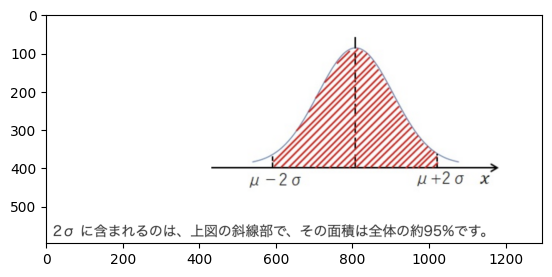

In [46]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("スクリーンショット 2024-05-09 8.15.56.png")
imgplot = plt.imshow(img)

### 今勉強している拡散モデルでやってみる
今回はデータから同じデータを生成したが、拡散モデルではデータからノイズを生成し、ノイズからデータを復元するモデルを学習する。より異常部分が明確になるかも